## Is it a duck or a swan?

In [20]:
!pip install -Uqq fastai duckduckgo_search

In [12]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=90):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('duck', max_images=1)
urls[0]

Searching for 'duck'


'https://www.captainmitchs.com/wp-content/uploads/2018/01/wood-duck-PFYHVZN.jpg'

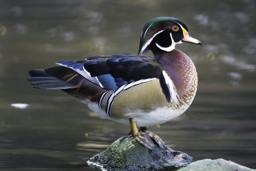

In [6]:
from fastdownload import download_url
dest = 'duck.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'swan'


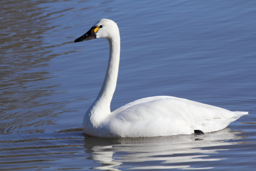

In [7]:
download_url(search_images('swan', max_images=1)[0], 'swan.jpg', show_progress=False)
Image.open('swan.jpg').to_thumb(256,256)

In [13]:
searches = 'duck','swan'
path = Path('duck_or_swan')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(30)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'duck photo'
Searching for 'swan photo'


## Step 2: Train our model

In [14]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

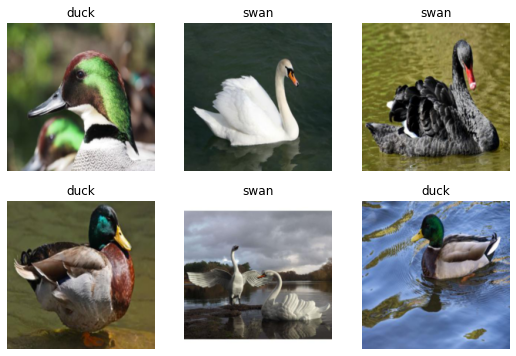

In [15]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.023275,0.896528,0.260870,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.177322,0.105065,0.065217,00:29
1,0.109635,0.016510,0.000000,00:29
2,0.076812,0.011866,0.000000,00:29


In [23]:
bird,_,probs = learn.predict(PILImage.create('duck.jpg'))
Image.open('duck.jpg').to_thumb(256,256)
print(f"This is a: {bird}.")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a swan: {probs[1]:.4f}")

This is a: duck.
Probability it's a duck: 0.9999
Probability it's a swan: 0.0001


In [22]:
bird,_,probs = learn.predict(PILImage.create('swan.jpg'))
Image.open('duck.jpg').to_thumb(256,256)
print(f"This is a: {bird}.")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a swan: {probs[1]:.4f}")

This is a: swan.
Probability it's a duck: 0.0000
Probability it's a swan: 1.0000
